In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys  
from pathlib import Path

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.data_splitting as datasplit
import src.metrics as metrics
import src.utils as utils


Cargo el dataset en df y printeo la informacion para tener un pantallazo inicial.

In [2]:

df = pd.read_csv(ROOT / "data" / "casas_dev.csv")
df_test = pd.read_csv(ROOT / "data" / "casas_test.csv")

print(df.info())
print(df.head())
print(df.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1545 non-null   float64
 1   tipo              1600 non-null   object 
 2   Área              1600 non-null   float64
 3   metros_cubiertos  1600 non-null   float64
 4   unidades          1600 non-null   object 
 5   ambientes         1600 non-null   int64  
 6   pisos             748 non-null    float64
 7   pileta            1600 non-null   bool   
 8   lat               1600 non-null   float64
 9   lon               1600 non-null   float64
 10  edad              1451 non-null   float64
dtypes: bool(1), float64(7), int64(1), object(2)
memory usage: 126.7+ KB
None
          precio   tipo        Área  metros_cubiertos unidades  ambientes  \
0  159001.587058  depto  721.976728        703.066245     sqft          5   
1   42435.625078   casa  229.512155        113.935

Viendo la informacion del dataset, se ven varias columnas con datos faltantes. En primer lugar hay que eliminar aquellas filas que tengan faltante el precio, ya que este es mi target. Después pasar las columnas categoricas a binarias como la columna "Tipo". Luego rellenar datos faltantes en columnas que me parezcan relevantes. Por ultimo algunos ajustes menores como pasar todo a la misma unidad y desacerme de la columna "unidad" ya que no aporta informacion relevante.

c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

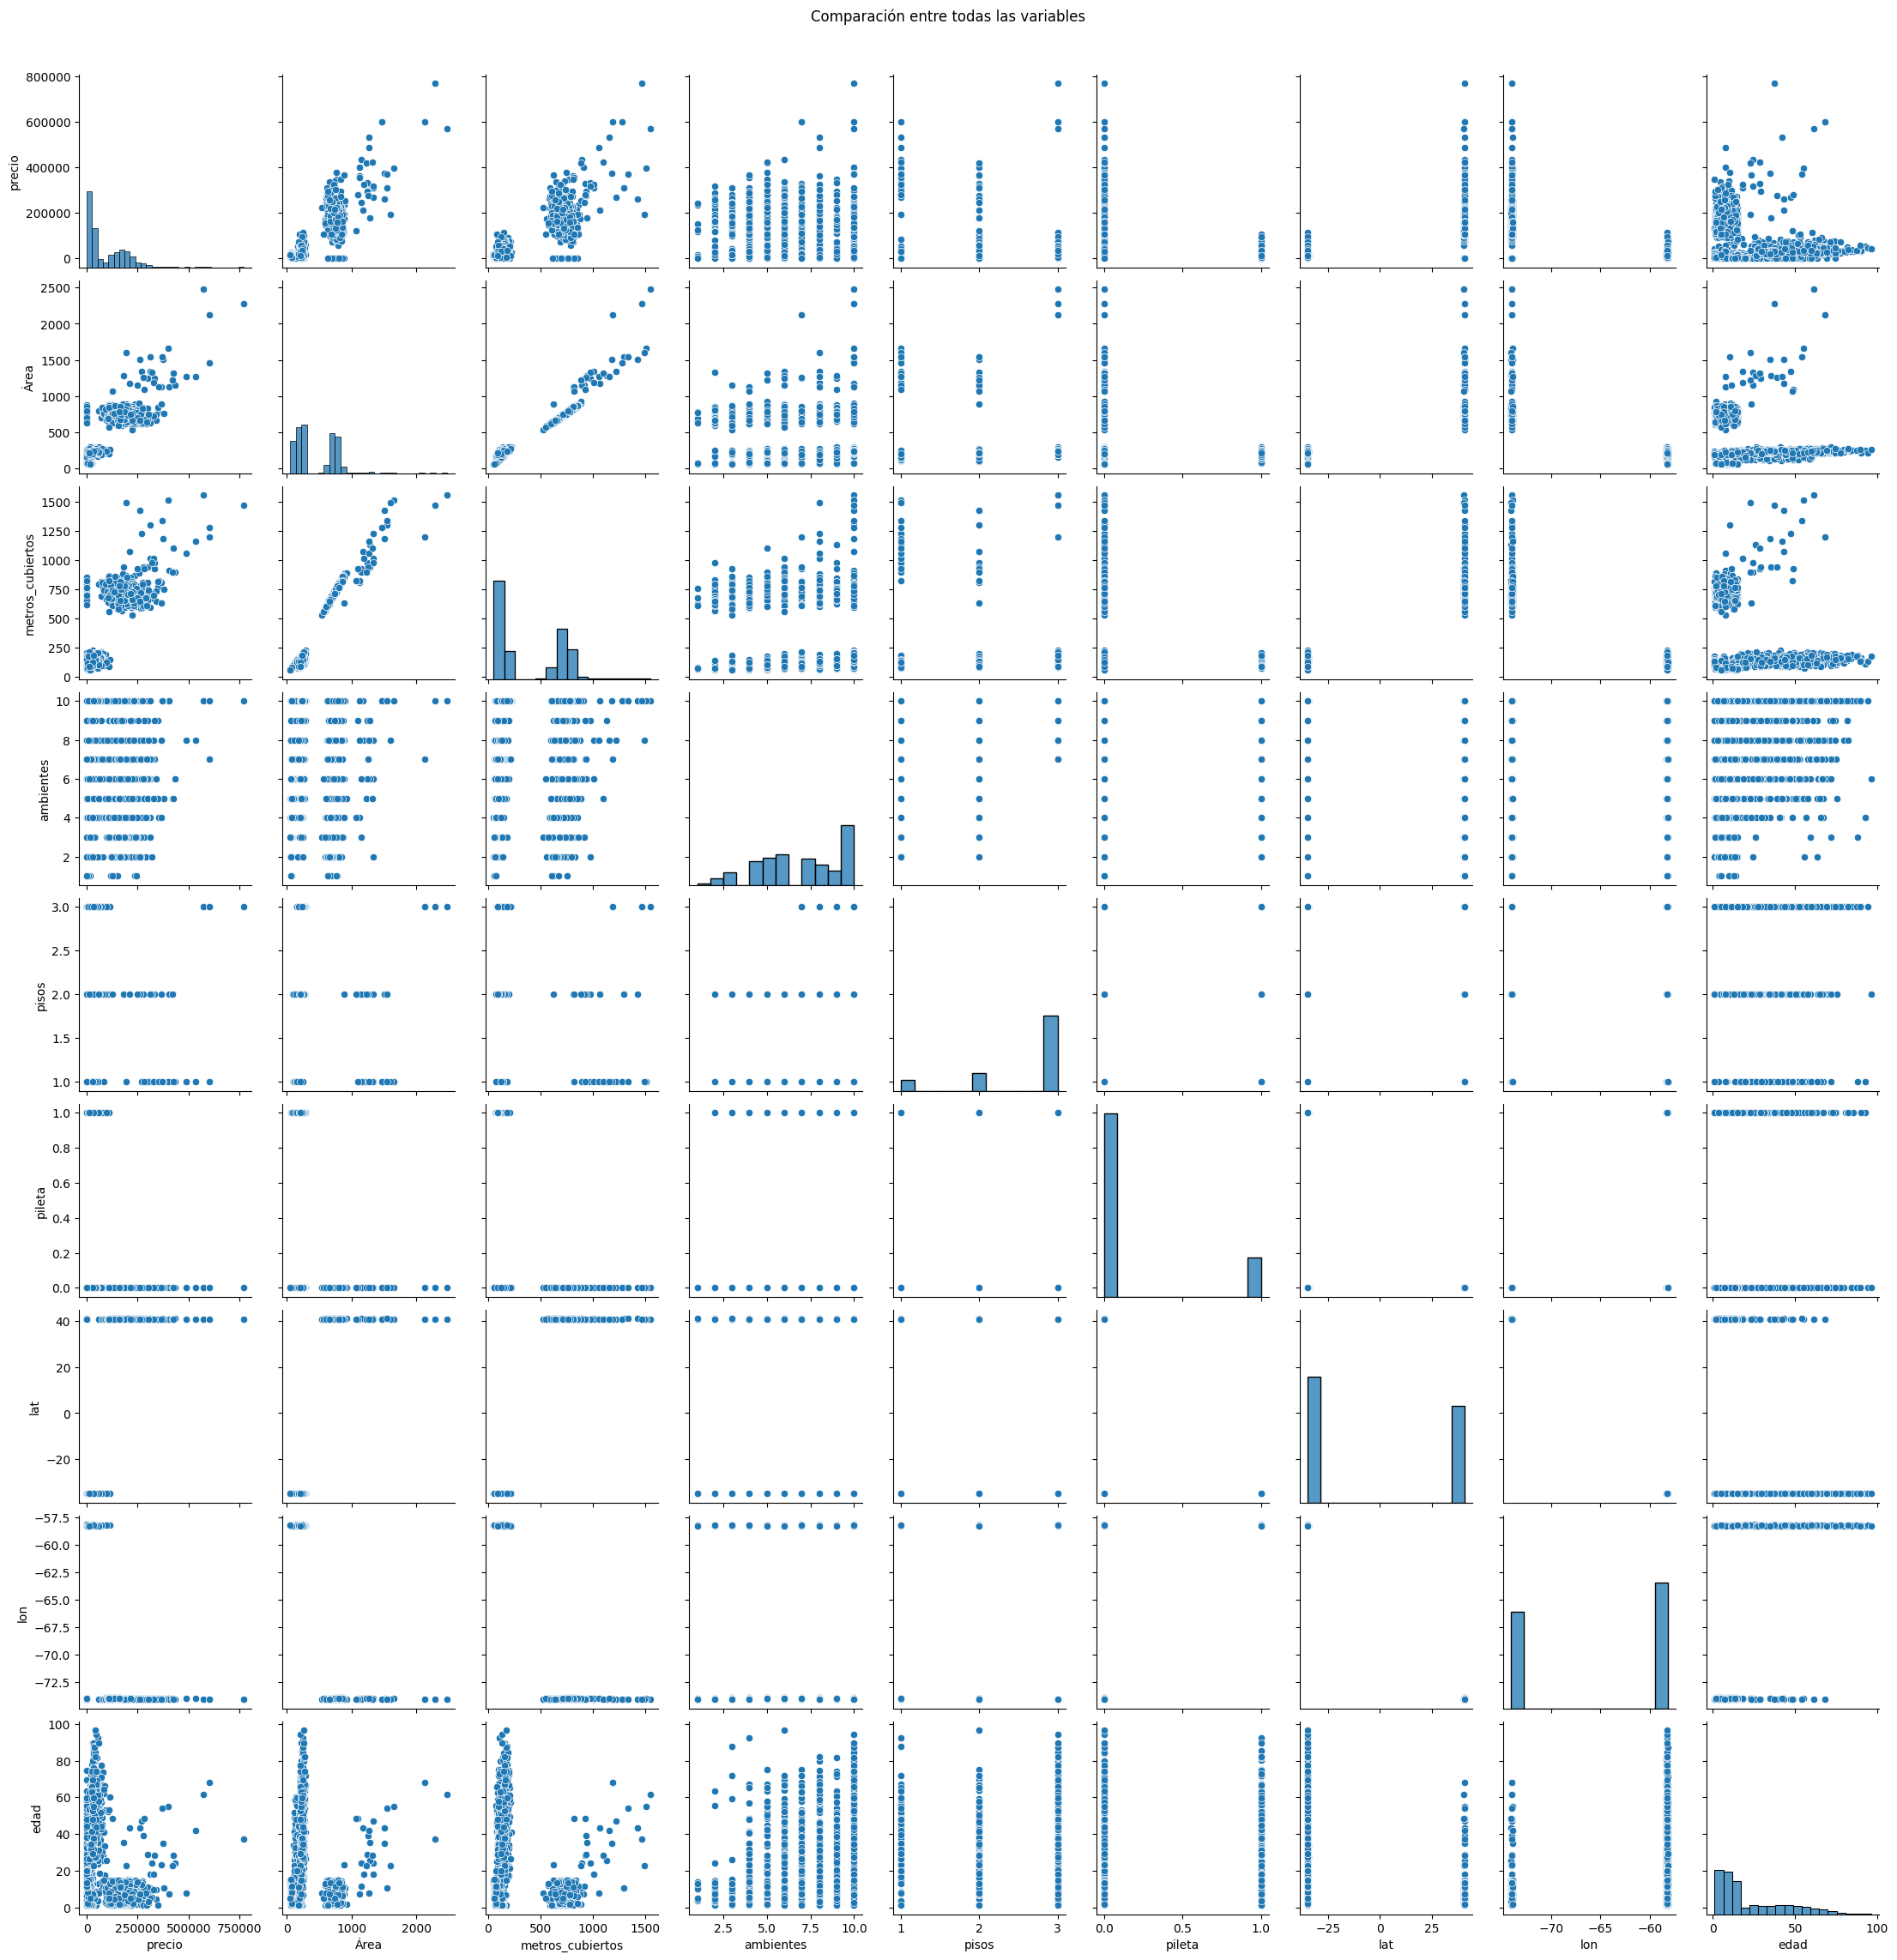

In [3]:
#Hacer scatter plots de las columnas para comparar todas con todas
sns.pairplot(df)
plt.suptitle('Comparación entre todas las variables', y=1.02)
plt.show()

Algunos comentarios sobre el pair plot:

- Parece que todas las casas mas caras no poseen pileta.

- Lat y lon estan divididos en dos grupos muy marcados. Lo que indica que las propiedades pertenecen a dos lugares distintos. Viendo la comparacion con el precio veo que hay una que posee precios mucho mayores. Esta corresponde a valores de lat positivos y valores de lon menores a -70. Creo que despues me va a ser útil crear una columna que me diferencie dependiendo de que zona es la propiedad. Dejo los graficos a continuacion donde se ve lo que estoy queriendo describir

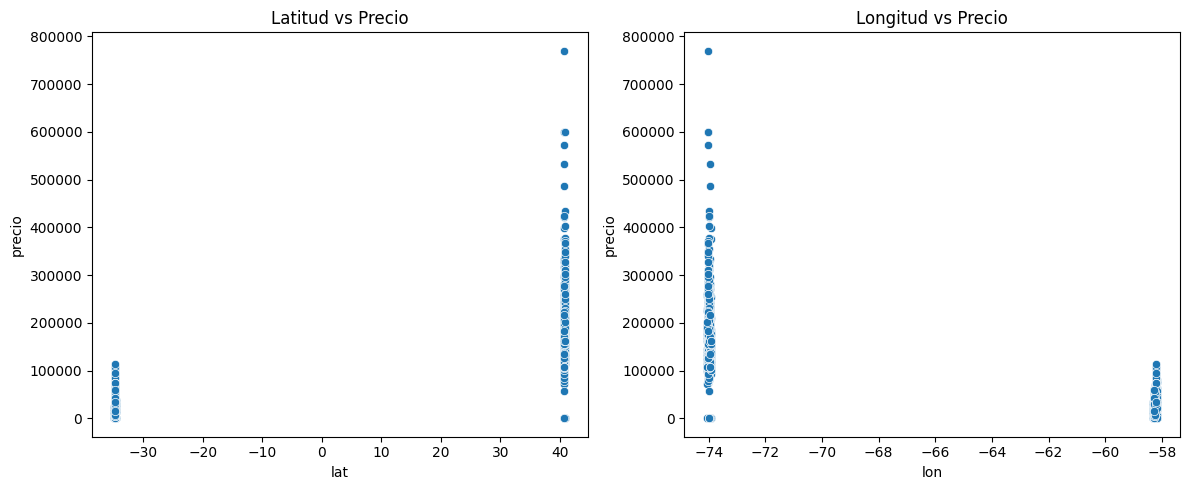

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='lat', y='precio', data=df)
plt.title('Latitud vs Precio')

plt.subplot(1, 2, 2)
sns.scatterplot(x='lon', y='precio', data=df)
plt.title('Longitud vs Precio')

plt.tight_layout()
plt.show()

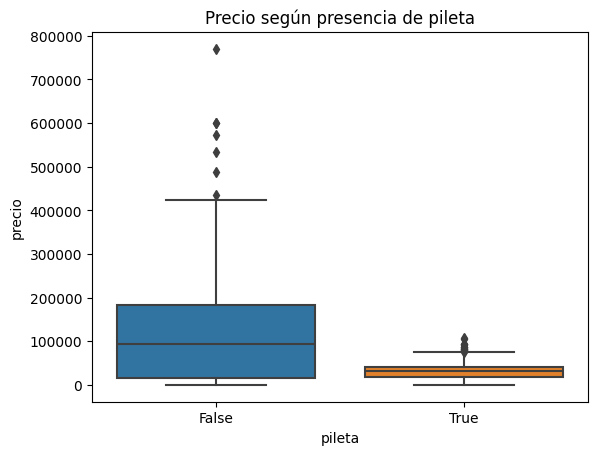

In [5]:
sns.boxplot(x='pileta', y='precio', data=df)
plt.title('Precio según presencia de pileta')
plt.show()

- Para la columna pisos, una de las columnas con datos faltantes, tengo solo tres valores posibles. Luego de analizar el dataset mas en profundidad se entiende que aquellas filas con "pisos" faltante son aquellas que corresponden al "tipo" depto. Por una cuestion de logica voy a elegir rellenar estos datos con un valor de 1 piso, asumiendo que todos los deptos tienen 1 solo piso en su gran mayoria.

- La columna "edad" no tiene una distribución simetrica, por lo que para rellenar los datos faltantes voy a utilizar la mediana. 

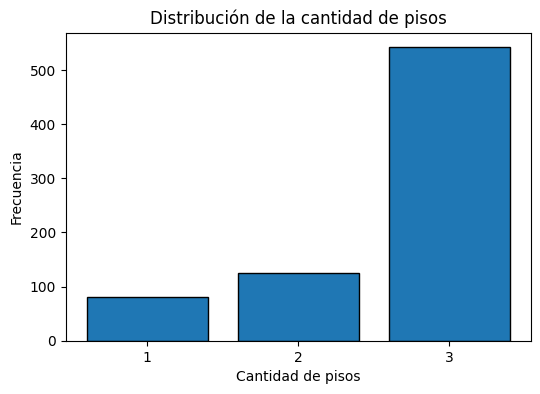

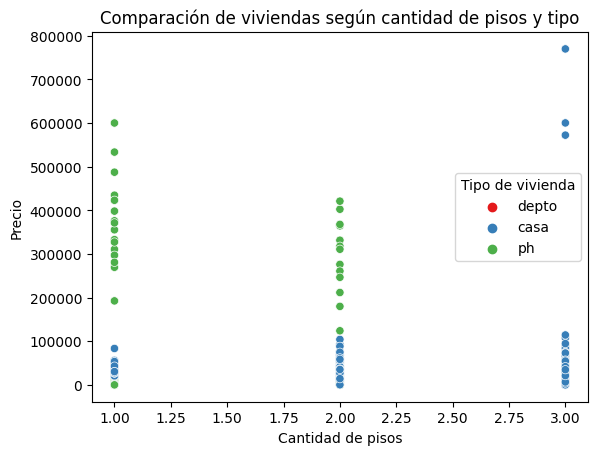

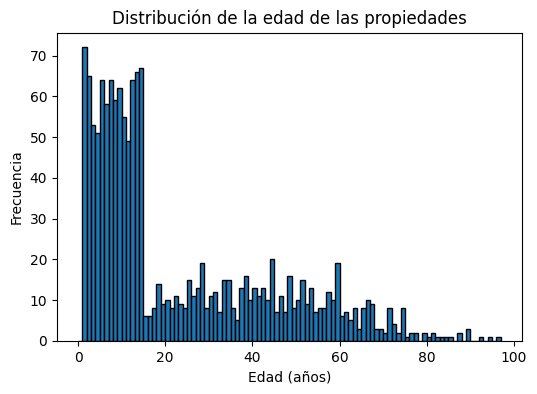

In [6]:
# Calculo la frecuencia de cada valor en la columna pisos
pisos_freq = df['pisos'].value_counts().sort_index()

# Grafico la frecuencia de cada cantidad de pisos
plt.figure(figsize=(6,4))
plt.bar(pisos_freq.index.astype(int), pisos_freq.values, edgecolor='black')
plt.xlabel('Cantidad de pisos')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de pisos')
plt.xticks(pisos_freq.index.astype(int))
plt.show()

# Comparación de viviendas según cantidad de pisos y tipo
sns.scatterplot(data=df, x='pisos', y='precio', hue='tipo', palette='Set1')
plt.xlabel('Cantidad de pisos')
plt.ylabel('Precio')
plt.title('Comparación de viviendas según cantidad de pisos y tipo')
plt.legend(title='Tipo de vivienda')
plt.show()

# Histograma de la columna edad
plt.figure(figsize=(6,4))
plt.hist(df['edad'].dropna(), bins=range(0, int(df['edad'].max())+2), edgecolor='black')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la edad de las propiedades')
plt.show()

Empiezo con la limpieza del dataset:

In [7]:
# Creo una copia de los datos para limpiar
df_clean = df.copy() 
df_clean_test = df_test.copy()

# Elimino filas con precio Nan o precio 0
df_clean = df_clean[df_clean['precio'].notna() & (df_clean['precio'] != 0)]
df_clean_test = df_clean_test[df_clean_test['precio'].notna() & (df_clean_test['precio'] != 0)]

# Convierto los valores de 'area' de sqft a m2 donde corresponda
df_clean.loc[df_clean['unidades'] == 'sqft', 'Área'] = df_clean.loc[df_clean['unidades'] == 'sqft', 'Área'] * 0.092903
df_clean_test.loc[df_clean_test['unidades'] == 'sqft', 'Área'] = df_clean_test.loc[df_clean_test['unidades'] == 'sqft', 'Área'] * 0.092903

# Eliminar la columna unidades
df_clean.drop(columns=['unidades'], inplace=True)
df_clean_test.drop(columns=['unidades'], inplace=True)

# Calculo la mediana de la columna edad y la relleno
df_clean['edad'].fillna(df_clean['edad'].median(), inplace=True)
df_clean_test['edad'].fillna(df_clean_test['edad'].median(), inplace=True)

# Relleno la columna pisos con 1 si el tipo es departamento
df_clean.loc[df_clean['tipo'] == 'depto', 'pisos'] = 1
df_clean_test.loc[df_clean_test['tipo'] == 'depto', 'pisos'] = 1

# Codificar la columna 'tipo' usando la función de preprocesamiento
df_clean = pre.encode_tipo_column(df_clean)
df_clean_test = pre.encode_tipo_column(df_clean_test)

print(df_clean.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   precio            1488 non-null   float64
 1   Área              1488 non-null   float64
 2   metros_cubiertos  1488 non-null   float64
 3   ambientes         1488 non-null   int64  
 4   pisos             1488 non-null   float64
 5   pileta            1488 non-null   bool   
 6   lat               1488 non-null   float64
 7   lon               1488 non-null   float64
 8   edad              1488 non-null   float64
 9   depto             1488 non-null   bool   
 10  ph                1488 non-null   bool   
dtypes: bool(3), float64(7), int64(1)
memory usage: 109.0 KB
None


C:\Users\Lucas\AppData\Local\Temp\ipykernel_112\2869167375.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['edad'].fillna(df_clean['edad'].median(), inplace=True)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_112\2869167375.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

Separo en Train y Validation, y normailzo los datos usando el mu y sigma de train

In [8]:
#Separo en train y validation
train_df, val_df = datasplit.split_train_val(df_clean,train_frac=0.8, random_state=42)

# Normalizo usando SOLO info de train
train_df_norm, val_df_norm, mu, sigma = pre.normalize(train_df, val_df, target_name="precio")


Modelo M1: Regresion Lineal Simple, Area como unica caracteristica

In [9]:
# Modelo M1 solo con Area con Pseudoinversa
X_train_m1 = train_df_norm[["Área"]].values
y_train_m1 = train_df_norm["precio"].values

X_val_m1 = val_df_norm[["Área"]].values
y_val_m1 = val_df_norm["precio"].values

features_m1 = ["Área"]

modelo_m1_svd = models.RegresionLineal(X_train_m1, y_train_m1, feature_names=features_m1)
modelo_m1_svd.entrenar_pseudoinversa()

print("Coeficientes del modelo M1 entrenado con Pseudoinversa:")
modelo_m1_svd.imprimir_coeficientes()

modelo_m1_gd = models.RegresionLineal(X_train_m1, y_train_m1, feature_names=features_m1)
modelo_m1_gd.entrenar_gradiente_descendente()

print("Coeficientes del modelo M1 entrenado con Gradiente Descendente:")
modelo_m1_gd.imprimir_coeficientes()

Coeficientes del modelo M1 entrenado con Pseudoinversa:
  Bias: 97681.6452
  Área: -54120.8415
Coeficientes del modelo M1 entrenado con Gradiente Descendente:
  Bias: 97677.4282
  Área: -54118.5050


Modelo M2: Regresion Lineal Simple, Area y Pileta como caracteristicas

In [10]:
# Modelo M2 con Area y Pileta con Pseudoinversa
X_train_m2 = train_df_norm[["Área", "pileta"]].values
y_train_m2 = train_df_norm["precio"].values

X_val_m2 = val_df_norm[["Área", "pileta"]].values
y_val_m2 = val_df_norm["precio"].values

features_m2 = ["Área", "Pileta"]

modelo_m2 = models.RegresionLineal(X_train_m2, y_train_m2, feature_names=features_m2)
modelo_m2.entrenar_pseudoinversa()

print("Coeficientes del modelo M2 entrenado con Pseudoinversa:")
modelo_m2.imprimir_coeficientes()

modelo_m2_gd = models.RegresionLineal(X_train_m2, y_train_m2, feature_names=features_m2)
modelo_m2_gd.entrenar_gradiente_descendente()

print("Coeficientes del modelo M2 entrenado con Gradiente Descendente:")
modelo_m2_gd.imprimir_coeficientes()

Coeficientes del modelo M2 entrenado con Pseudoinversa:
  Bias: 99200.2801
  Área: -52453.9135
  Pileta: -8524.4128
Coeficientes del modelo M2 entrenado con Gradiente Descendente:
  Bias: 98076.9125
  Área: -53680.0114
  Pileta: -2870.8232


3.2) Benito está evaluando la posibilidad de construir una pileta. ¿Cómo afectaría la cons-
trucción de una pileta al precio de su propiedad? Explique cómo llegó a este resultado

Si me baso en estrictamente en los resultados obtenidos hasta el momento, viendo que el coeficiente de pileta es negativo para ambos metodos, le diria que construir una pileta reduciría el precio de su propiedad. Sin embargo si lo pienso desde la logica, lo mas probable es que simplemente las propiedades que no tengan pileta son mas caras por alguna otra caracteristica y no por la pileta.

Modelo M3: Regresion Simple con 6 caracteristicas

In [11]:
train_df, val_df = datasplit.split_train_val(df_clean,train_frac=0.8, random_state=42)

#Modelo M3 usando 6 caracteristicas
X_train_m3 = train_df_norm[["Área", "pileta", "ambientes", "edad", "metros_cubiertos", "pisos"]].values
y_train_m3 = train_df_norm["precio"].values

X_val_m3 = val_df_norm[["Área", "pileta", "ambientes", "edad", "metros_cubiertos", "pisos"]].values
y_val_m3 = val_df_norm["precio"].values

features_m3 = ["Área", "Pileta", "Ambientes", "Edad", "Metros Cubiertos", "Pisos"]

modelo_m3 = models.RegresionLineal(X_train_m3, y_train_m3, feature_names=features_m3)
modelo_m3.entrenar_pseudoinversa()

print("Coeficientes del modelo M3 entrenado con Pseudoinversa:")
modelo_m3.imprimir_coeficientes()


modelo_m3_gd = models.RegresionLineal(X_train_m3, y_train_m3, feature_names=features_m3)
modelo_m3_gd.entrenar_gradiente_descendente()

print("Coeficientes del modelo M3 entrenado con Gradiente Descendente:")
modelo_m3_gd.imprimir_coeficientes()



Coeficientes del modelo M3 entrenado con Pseudoinversa:
  Bias: 96774.0157
  Área: -5436.6991
  Pileta: 5094.7132
  Ambientes: -4356.7125
  Edad: 6602.0309
  Metros Cubiertos: 89997.6299
  Pisos: 7240.5436
Coeficientes del modelo M3 entrenado con Gradiente Descendente:
  Bias: 95990.3341
  Área: -4988.5912
  Pileta: 9074.8316
  Ambientes: -3380.0570
  Edad: 6980.4782
  Metros Cubiertos: 89414.9326
  Pisos: 4435.8889


In [12]:
# Construyo caracteristicas derivadas de las anteriores.

# Copio para no pisar el original
df_feat = df_clean.copy()
df_test_feat = df_clean_test.copy()

# Transformaciones numericas simples:

# Logaritmos
df_feat["log_area"] = np.log1p(df_feat["Área"])
df_feat["log_metros_cubiertos"] = np.log1p(df_feat["metros_cubiertos"])

# Para el set de Test
df_test_feat["log_area"] = np.log1p(df_test_feat["Área"])
df_test_feat["log_metros_cubiertos"] = np.log1p(df_test_feat["metros_cubiertos"])

# Polinomios
df_feat["area_squared"] = df_feat["Área"] ** 2
df_feat["edad_squared"] = df_feat["edad"] ** 2
df_feat["ambientes_squared"] = df_feat["ambientes"] ** 2

# Para el set de Test
df_test_feat["area_squared"] = df_test_feat["Área"] ** 2
df_test_feat["edad_squared"] = df_test_feat["edad"] ** 2
df_test_feat["ambientes_squared"] = df_test_feat["ambientes"] ** 2

# Raíces
df_feat["sqrt_area"] = np.sqrt(df_feat["Área"])
df_feat["sqrt_metros_cubiertos"] = np.sqrt(df_feat["metros_cubiertos"])

# Para el set de Test
df_test_feat["sqrt_area"] = np.sqrt(df_test_feat["Área"])
df_test_feat["sqrt_metros_cubiertos"] = np.sqrt(df_test_feat["metros_cubiertos"])

# Interacciones:

# Producto de variables que puedan tener efecto conjunto
df_feat["pisos_x_ambientes"] = df_feat["pisos"] * df_feat["ambientes"]
df_feat["edad_x_metros"] = df_feat["edad"] * df_feat["metros_cubiertos"]

# Para el set de Test
df_test_feat["pisos_x_ambientes"] = df_test_feat["pisos"] * df_test_feat["ambientes"]
df_test_feat["edad_x_metros"] = df_test_feat["edad"] * df_test_feat["metros_cubiertos"]


# Relaciones de tamaños
df_feat["relacion_cubiertos"] = df_feat["metros_cubiertos"] / (df_feat["Área"] + 1e-6)
df_feat["m2_por_ambiente"] = df_feat["metros_cubiertos"] / (df_feat["ambientes"] + 1e-6)
df_feat["densidad_construccion"] = df_feat["pisos"] / (df_feat["Área"] + 1e-6)

# Para el set de Test
df_test_feat["relacion_cubiertos"] = df_test_feat["metros_cubiertos"] / (df_test_feat["Área"] + 1e-6)
df_test_feat["m2_por_ambiente"] = df_test_feat["metros_cubiertos"] / (df_test_feat["ambientes"] + 1e-6)
df_test_feat["densidad_construccion"] = df_test_feat["pisos"] / (df_test_feat["Área"] + 1e-6)

# Zona (Mencionado anteriormente):

# Creo la variable zona y elimino las coordenadas
df_feat["zona"] = (df_feat["lat"] > 0).astype(int)
df_feat.drop(columns=["lat", "lon"], inplace=True)

# Para el set de Test
df_test_feat["zona"] = (df_test_feat["lat"] > 0).astype(int)
df_test_feat.drop(columns=["lat", "lon"], inplace=True)

# Interacción entre zona y tamaño
df_feat["zona_x_metros"] = df_feat["zona"] * df_feat["metros_cubiertos"]

# Para el set de Test
df_test_feat["zona_x_metros"] = df_test_feat["zona"] * df_test_feat["metros_cubiertos"]

# Chequeo
df_feat.info()
df_feat.describe()
df_feat.head()



<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 0 to 1599
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   precio                 1488 non-null   float64
 1   Área                   1488 non-null   float64
 2   metros_cubiertos       1488 non-null   float64
 3   ambientes              1488 non-null   int64  
 4   pisos                  1488 non-null   float64
 5   pileta                 1488 non-null   bool   
 6   edad                   1488 non-null   float64
 7   depto                  1488 non-null   bool   
 8   ph                     1488 non-null   bool   
 9   log_area               1488 non-null   float64
 10  log_metros_cubiertos   1488 non-null   float64
 11  area_squared           1488 non-null   float64
 12  edad_squared           1488 non-null   float64
 13  ambientes_squared      1488 non-null   int64  
 14  sqrt_area              1488 non-null   float64
 15  sqrt_metr

,precio,Área,metros_cubiertos,ambientes,pisos,pileta,edad,depto,ph,log_area,...,ambientes_squared,sqrt_area,sqrt_metros_cubiertos,pisos_x_ambientes,edad_x_metros,relacion_cubiertos,m2_por_ambiente,densidad_construccion,zona,zona_x_metros
0,159001.587058,67.073804,703.066245,5,1.0,False,13.061086,True,False,4.220592,...,25,8.189860,26.515396,5.0,9182.808905,10.481979,140.613221,0.014909,1,703.066245
1,42435.625078,229.512155,113.935741,4,1.0,True,67.202318,False,False,5.440304,...,16,15.149659,10.674069,4.0,7656.745902,0.496426,28.483928,0.004357,0,0.000000
3,135972.861876,72.158654,747.693158,5,1.0,False,13.835526,True,False,4.292630,...,25,8.494625,27.343978,5.0,10344.728187,10.361795,149.538602,0.013858,1,747.693158
4,49758.465224,249.165942,102.023922,5,2.0,False,63.200110,False,False,5.522124,...,25,15.784991,10.100689,10.0,6447.923121,0.409462,20.404780,0.008027,0,0.000000
5,7256.796507,170.849136,77.355172,6,2.0,True,4.305892,False,False,5.146617,...,36,13.070927,8.795179,12.0,333.083056,0.452769,12.892527,0.011706,0,0.000000


Modelo M4: Regresion Lineal M3 + Feature Engineering

In [13]:
# Separo los datos en entrenamiento y validación
train_df, val_df = datasplit.split_train_val(df_feat,train_frac=0.8, random_state=42)

# Normalizo usando SOLO info de train
train_df_norm, val_df_norm, mu, sigma = pre.normalize(train_df, val_df, target_name="precio")

#Normalizo el set de test usando mu y sigma de train
# Columnas numéricas sin el target
num_cols = train_df.select_dtypes(include="number").columns.drop("precio")



In [14]:
# Modelo M4 usando todas las caracteristicas
X_train_m4 = train_df_norm.drop(columns=['precio']).values
y_train_m4 = train_df_norm['precio'].values

X_val_m4 = val_df_norm.drop(columns=['precio']).values
y_val_m4 = val_df_norm['precio'].values

features_m4 = train_df_norm.drop(columns=['precio']).columns.tolist()

modelo_m4 = models.RegresionLineal(X_train_m4, y_train_m4, feature_names=features_m4)
modelo_m4.entrenar_pseudoinversa()

print("Coeficientes del modelo M4 entrenado con Pseudoinversa:")
modelo_m4.imprimir_coeficientes()

modelo_m4_gd = models.RegresionLineal(X_train_m4, y_train_m4, feature_names=features_m4)
modelo_m4_gd.entrenar_gradiente_descendente()

print("Coeficientes del modelo M4 entrenado con Gradiente Descendente:")
modelo_m4_gd.imprimir_coeficientes()


Coeficientes del modelo M4 entrenado con Pseudoinversa:
  Bias: 173909.9742
  Área: -1053118.2337
  metros_cubiertos: 754729.0321
  ambientes: 815.3997
  pisos: 35946.1503
  pileta: 5566.0857
  edad: 9218.9668
  depto: -139898.0819
  ph: -67645.9515
  log_area: -917188.1006
  log_metros_cubiertos: 522785.3872
  area_squared: 174424.3499
  edad_squared: 1093.8449
  ambientes_squared: 3267.4072
  sqrt_area: 1652819.9106
  sqrt_metros_cubiertos: -1147945.9616
  pisos_x_ambientes: -10620.2782
  edad_x_metros: -11760.8695
  relacion_cubiertos: -380803.5683
  m2_por_ambiente: -2162.6271
  densidad_construccion: -18975.3727
  zona: 452585.8023
  zona_x_metros: -125138.7129
Coeficientes del modelo M4 entrenado con Gradiente Descendente:
  Bias: 81268.4461
  Área: 5784.3331
  metros_cubiertos: 17251.3479
  ambientes: -1140.0817
  pisos: -273.2299
  pileta: 10097.0869
  edad: -2557.0294
  depto: 25073.7016
  ph: 15929.1892
  log_area: 4777.7178
  log_metros_cubiertos: 10503.0493
  area_squared: 

Modelo M5: Regresión Lineal con 50 características.

In [15]:
# Modelo M5 con 50 caracteristicas

# Uso estas 5 caracteristicas como base
X_base = df_feat[["Área", "metros_cubiertos", "ambientes", "edad", "pisos"]].copy()

# Creo nuevas features polinómicas
X_poly = pd.DataFrame()

for col in X_base.columns:
    for p in range(1, 13):  # potencias de 1 hasta 12
        X_poly[f"{col}^{p}"] = X_base[col] ** p

# Me quedo con las primeras 50
X_poly = X_poly.iloc[:, :50]

X = X_poly.values
y = df_feat["precio"].values

X = pd.DataFrame(X, columns=X_poly.columns[:50])
X["precio"] = y

# Separo los datos en entrenamiento y validación
train_df, val_df = datasplit.split_train_val(X,train_frac=0.8, random_state=42)

# Normalizo usando SOLO info de train
train_df_norm, val_df_norm, mu, sigma = pre.normalize(train_df, val_df, target_name="precio")

X_train_m5 = train_df_norm.drop(columns=['precio']).values
y_train_m5 = train_df_norm['precio'].values

X_val_m5 = val_df_norm.drop(columns=['precio']).values
y_val_m5 = val_df_norm['precio'].values

features_m5 = train_df_norm.drop(columns=['precio']).columns.tolist()



In [16]:
# Entrenamiento del modelo M5

modelo_m5 = models.RegresionLineal(X_train_m5, y_train_m5, feature_names=features_m5)
modelo_m5.entrenar_pseudoinversa()

print("Coeficientes del modelo M5 entrenado con Pseudoinversa:")
modelo_m5.imprimir_coeficientes()

modelo_m5_gd = models.RegresionLineal(X_train_m5, y_train_m5, feature_names=features_m5)
modelo_m5_gd.entrenar_gradiente_descendente()

print("Coeficientes del modelo M5 entrenado con Gradiente Descendente:")
modelo_m5_gd.imprimir_coeficientes()

Coeficientes del modelo M5 entrenado con Pseudoinversa:
  Bias: 97681.6463
  Área^1: -1435664782.9117
  Área^2: 19183148610.4943
  Área^3: -125202190618.3978
  Área^4: 514741447642.7329
  Área^5: -1452488015775.5447
  Área^6: 2913458166790.2622
  Área^7: -4202008458087.3247
  Área^8: 4334819182187.1772
  Área^9: -3124986302776.9346
  Área^10: 1496749528774.5090
  Área^11: -428258319180.8898
  Área^12: 55427508761.2216
  metros_cubiertos^1: -18094617.8973
  metros_cubiertos^2: 249872452.7991
  metros_cubiertos^3: -1979613992.4606
  metros_cubiertos^4: 11225871781.0682
  metros_cubiertos^5: -45394634963.7095
  metros_cubiertos^6: 127883154882.6232
  metros_cubiertos^7: -249719595838.2571
  metros_cubiertos^8: 336420359953.2244
  metros_cubiertos^9: -306867555772.0611
  metros_cubiertos^10: 180994872776.6201
  metros_cubiertos^11: -62297342146.4708
  metros_cubiertos^12: 9503066150.6487
  ambientes^1: 1105293.5402
  ambientes^2: -13283533.6081
  ambientes^3: 61383383.5514
  ambientes^4: -

4.3) ¿Qué resultados esperaba obtener con estos experimentos?


Si comparamos M3 con M4 esperaria una mejora aunque sea minima por las caracteristicas nuevas que capten relaciones mas importantes con el precio. Entonces espero mejor ECM y que generalice mejor.

En cuanto a M5 al tener tantas caracteristicas creo que corre el riesgo de overfittear sobre todo si no le aplico regularizacion. Por eso espero tal vez una mejor performance en test que en validation. 

Los siguientes graficos muestran la comparacion en el rendimiento entre estos modelos para ver si se condice con mi pensamiento inicial.

In [17]:
# Obtengo los resultados de cada modelo

results = {
    "M3": {
        "y_train": y_train_m3,
        "yhat_train": modelo_m3.predecir(X_train_m3),
        "y_val": y_val_m3,
        "yhat_val": modelo_m3.predecir(X_val_m3),
    },
    "M4": {
        "y_train": y_train_m4,
        "yhat_train": modelo_m4.predecir(X_train_m4),
        "y_val": y_val_m4,
        "yhat_val": modelo_m4.predecir(X_val_m4),
    },
    "M5": {
        "y_train": y_train_m5,
        "yhat_train": modelo_m5.predecir(X_train_m5),
        "y_val": y_val_m5,
        "yhat_val": modelo_m5.predecir(X_val_m5),
    }
}

results_gd = {
    "M3": {
        "y_train": y_train_m3,
        "yhat_train": modelo_m3_gd.predecir(X_train_m3),
        "y_val": y_val_m3,
        "yhat_val": modelo_m3_gd.predecir(X_val_m3),
    },
    "M4": {
        "y_train": y_train_m4,
        "yhat_train": modelo_m4_gd.predecir(X_train_m4),
        "y_val": y_val_m4,
        "yhat_val": modelo_m4_gd.predecir(X_val_m4),
    },
    "M5": {
        "y_train": y_train_m5,
        "yhat_train": modelo_m5_gd.predecir(X_train_m5),
        "y_val": y_val_m5,
        "yhat_val": modelo_m5_gd.predecir(X_val_m5),
    }
}


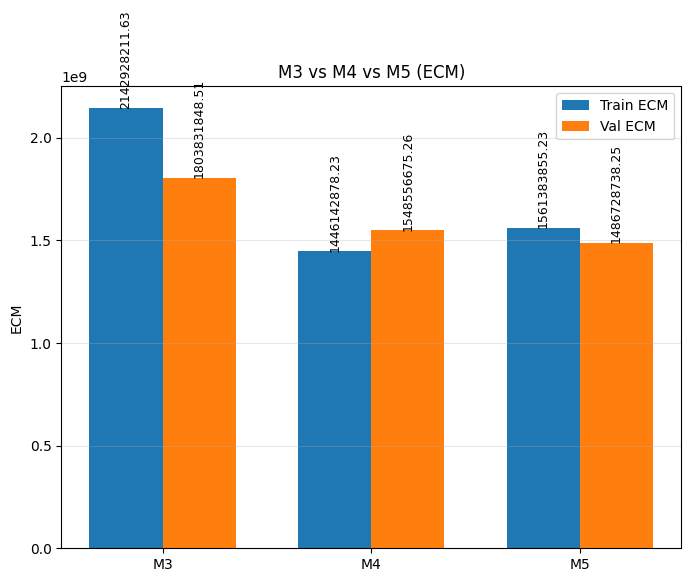

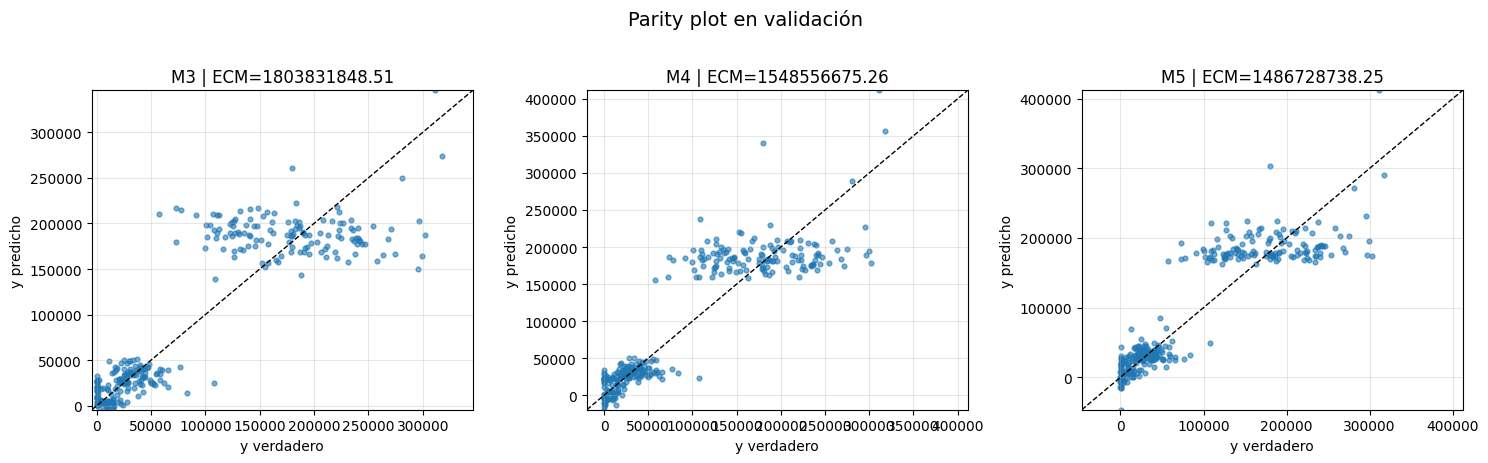

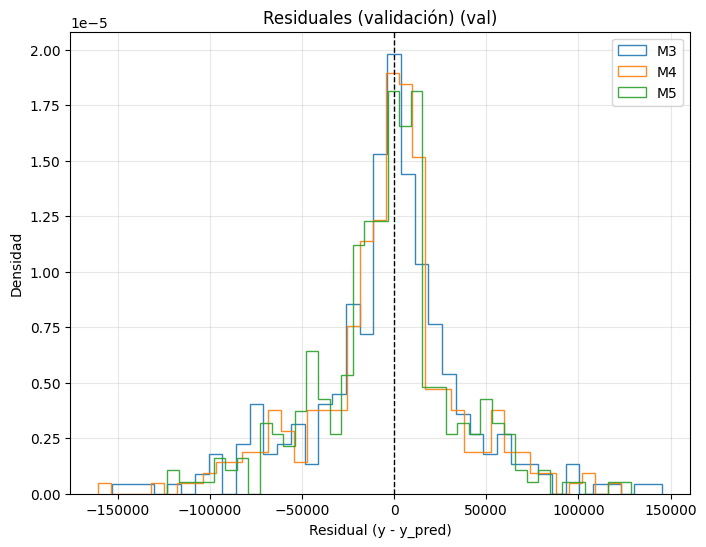

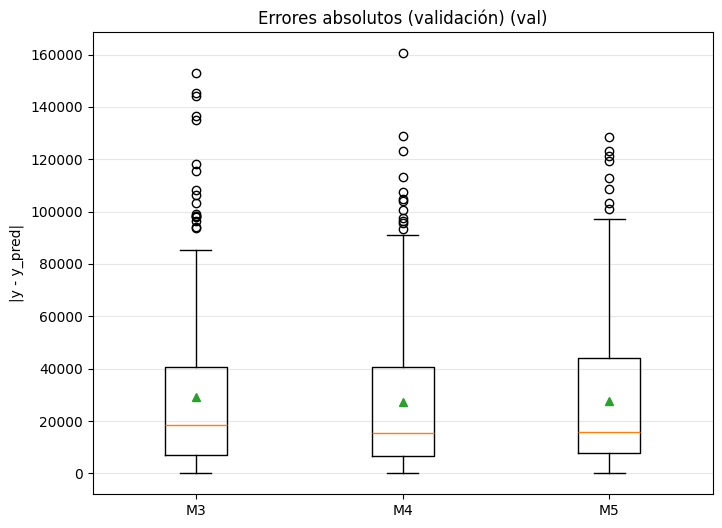

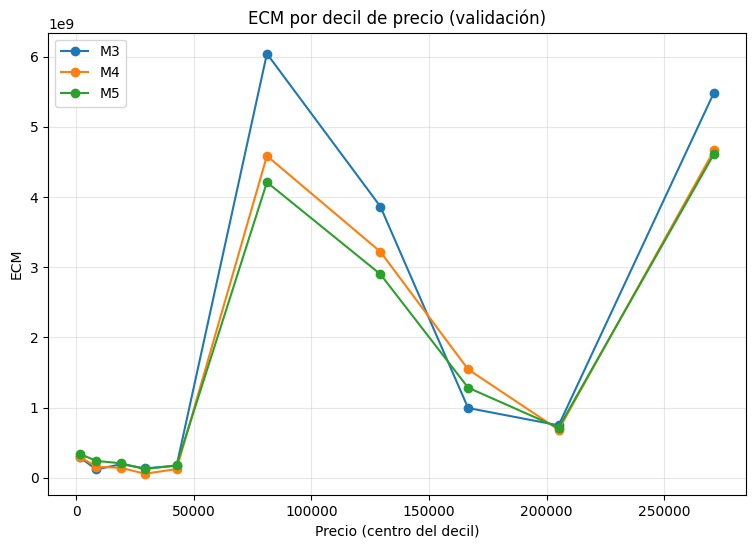

In [18]:
utils.plot_bar_mse(results, title="M3 vs M4 vs M5 (ECM)")
utils.plot_parity(results, title="Parity plot en validación")
utils.plot_residuals(results, which="val", bins=40, title="Residuales (validación)")
utils.plot_abs_error_box(results, which="val", title="Errores absolutos (validación)")
utils.plot_ecm_by_quantile(results, q=10, title="ECM por decil de precio (validación)")

Viendo los resultados, no se condicen del todo con mi pensamiento inicial, ya que M5 tiene menos error en Val que en Train. Y tambien menor error en Val comparado con M4. Sin embargo ambos son mejores que M3.

Regularización:

Modelo M4_L2: Con regularizacion L2 para las caracteristicas de M4

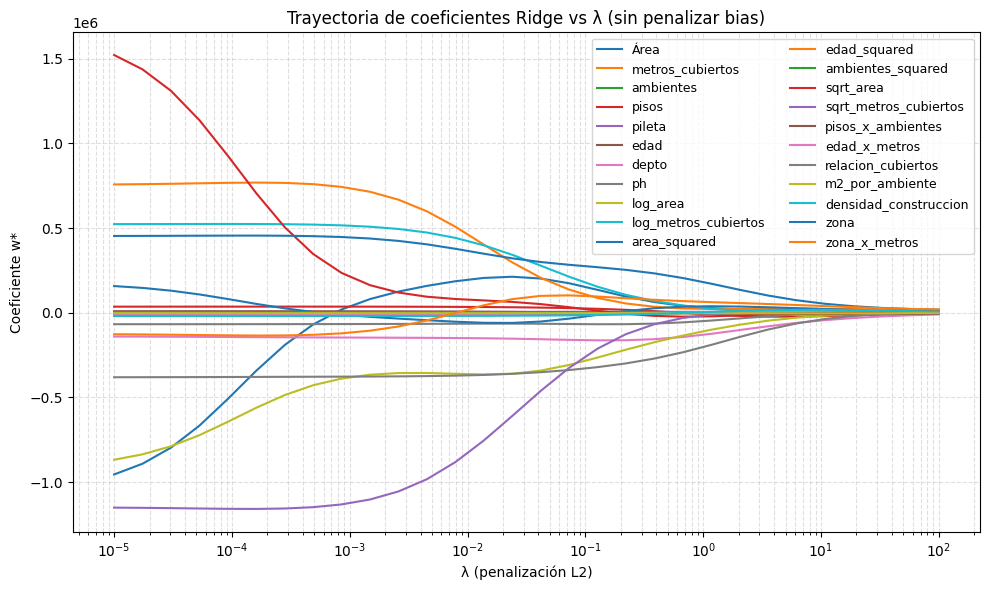

In [19]:
X_train_m4_L2 = X_train_m4
y_train_m4_L2 = y_train_m4
X_val_m4_L2 = X_val_m4
y_val_m4_L2 = y_val_m4

# hago un barrido de lambdas
lambdas = np.logspace(-5, 2, 30)  # desde 1e-3 hasta 1e6
Ws = []  # guardo los coefs

for lam in lambdas:
    modelo = models.RegresionLineal(X_train_m4_L2, y_train_m4_L2, estandarizar=False, feature_names=features_m4)
    modelo.entrenar_ridge(lam=lam)
    Ws.append(modelo.coef)

Ws = np.array(Ws)  

# gráfico: coeficientes (sin bias) vs lambda
plt.figure(figsize=(10, 6))
for j, name in enumerate(features_m4, start=1): 
    plt.plot(lambdas, Ws[:, j], label=name)

plt.xscale("log")
plt.xlabel("λ (penalización L2)")
plt.ylabel("Coeficiente w*")
plt.title("Trayectoria de coeficientes Ridge vs λ (sin penalizar bias)")
plt.legend(loc="upper right", ncol=2, fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


Ahora separo los coeficientes para ver los mejores 5 y los peores 5:

Top 5 (por max |coef| en el path):
             sqrt_area  max|w|=1.521e+06
  sqrt_metros_cubiertos  max|w|=1.158e+06
                  Área  max|w|=9.543e+05
              log_area  max|w|=8.675e+05
      metros_cubiertos  max|w|=7.682e+05

Bottom 5 (por max |coef| en el path):
       m2_por_ambiente  max|w|=3597
             ambientes  max|w|=3809
     ambientes_squared  max|w|=4851
          edad_squared  max|w|=5032
                pileta  max|w|=5613


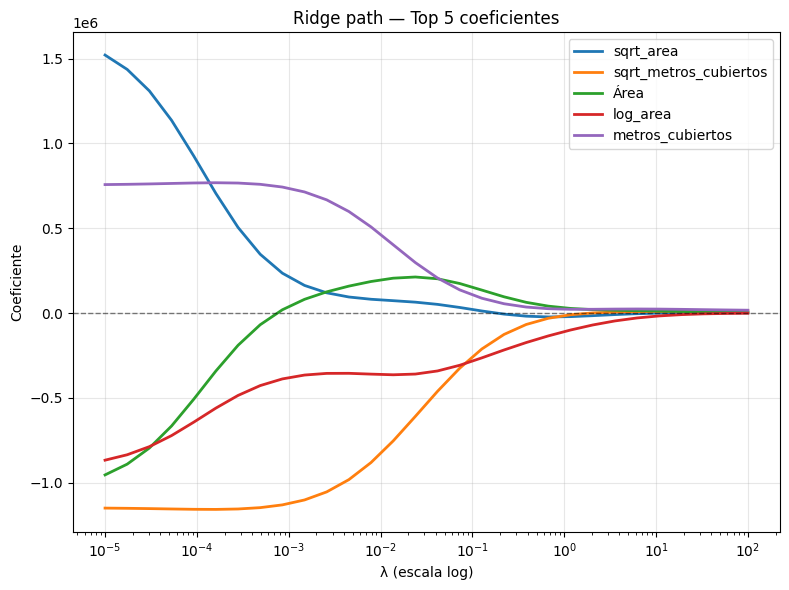

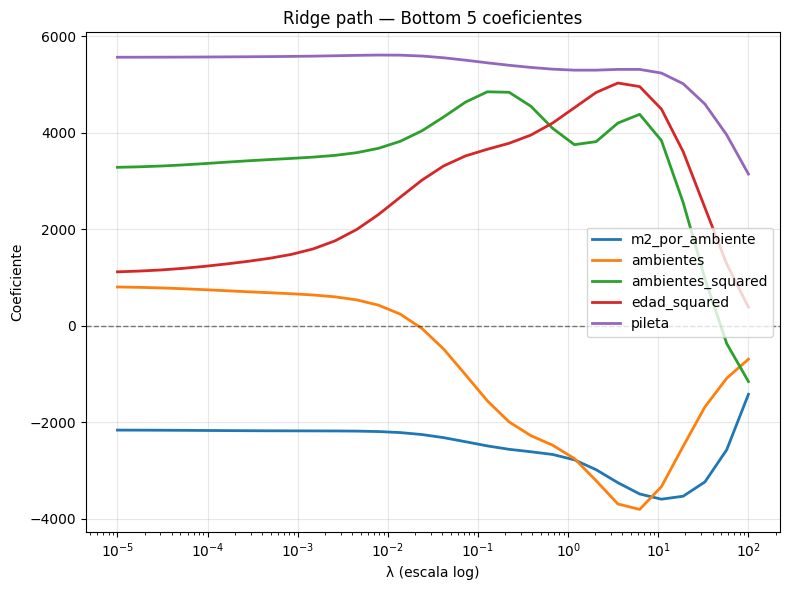

In [20]:

# Preparo los nombres sin el bias
if Ws.shape[1] == len(features_m4) + 1:
    Ws_no_b = Ws[:, 1:]
    feat_names = list(features_m4)
else:
    Ws_no_b = Ws
    feat_names = list(features_m4)

# Importancia por feature: max |coef| a lo largo del path 
importance = np.max(np.abs(Ws_no_b), axis=0)

# Top 5 y Bottom 5
order = np.argsort(importance)  # ascendente
bottom5_idx = order[:5]
top5_idx = order[-5:][::-1]

top5_feats = [feat_names[i] for i in top5_idx]
bottom5_feats = [feat_names[i] for i in bottom5_idx]

print("Top 5 (por max |coef| en el path):")
for i, f in zip(top5_idx, top5_feats):
    print(f"  {f:>20s}  max|w|={importance[i]:.4g}")

print("\nBottom 5 (por max |coef| en el path):")
for i, f in zip(bottom5_idx, bottom5_feats):
    print(f"  {f:>20s}  max|w|={importance[i]:.4g}")

# --- 4) Función para ploteo ---
def plot_ridge_subset(lambdas, Ws_sub, idxs, labels, title):
    plt.figure(figsize=(8,6))
    for j, i in enumerate(idxs):
        plt.semilogx(lambdas, Ws_sub[:, i], label=labels[j], linewidth=2)
    plt.axhline(0, color="k", lw=1, ls="--", alpha=0.5)
    plt.xlabel("λ (escala log)")
    plt.ylabel("Coeficiente")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Grafico
plot_ridge_subset(lambdas, Ws_no_b, top5_idx, top5_feats,
                  "Ridge path — Top 5 coeficientes")
plot_ridge_subset(lambdas, Ws_no_b, bottom5_idx, bottom5_feats,
                  "Ridge path — Bottom 5 coeficientes")


In [21]:
def lasso_path(
    X, y, feature_cols, lambdas,
    lr=0.5, max_iter=20000, tol=1e-8
):
    """
    Entrena LASSO para distintos λ y devuelve la matriz de coeficientes.
    Retorna:
      lambdas (array), Ws (len(λ) x (1 + n_features))
    """
    Ws = []
    for lam in lambdas:
        model = models.RegresionLineal(X, y, estandarizar=False, feature_names=feature_cols)
        model.entrenar_lasso(lam=lam, lr=lr, max_iter=max_iter, tol=tol, verbose=False)
        Ws.append(model.coef)
    return np.array(lambdas), np.array(Ws)

lambdas = np.logspace(-3, 6, 30)  # 1e-6 ... 1e4 (10 décadas)

Ls, Ws = lasso_path(
    X_train_m4_L2, y_train_m4_L2, features_m4, lambdas,
    lr=1e-3,              # o 5e-4
    max_iter=50000,
    tol=1e-9
)

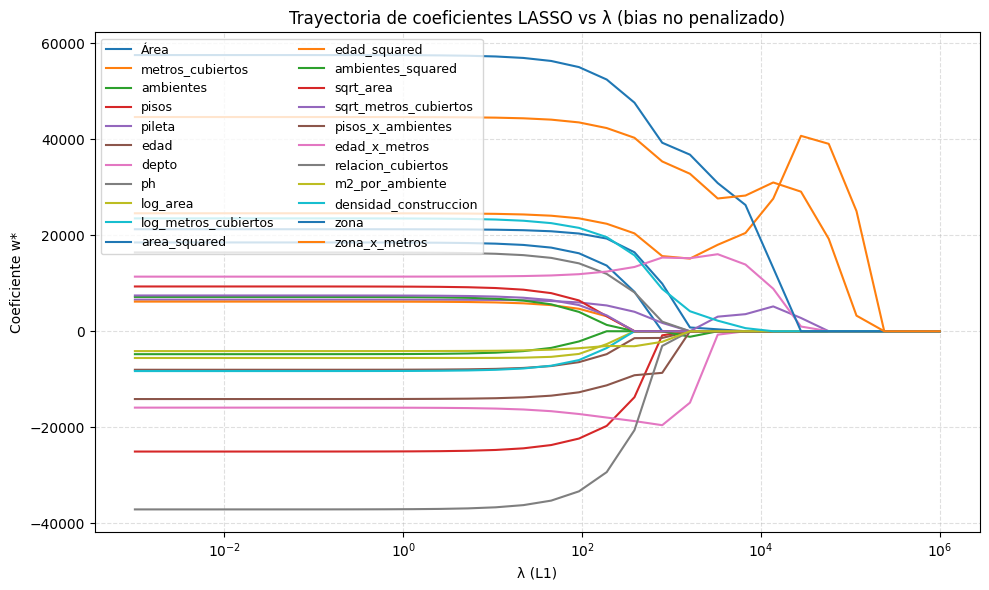

In [22]:
# Graficar trayectorias
plt.figure(figsize=(10, 6))
for j, name in enumerate(features_m4, start=1):  # start=1 saltea bias
    plt.plot(Ls, Ws[:, j], label=name)
plt.xscale("log")
plt.xlabel("λ (L1)")
plt.ylabel("Coeficiente w*")
plt.title("Trayectoria de coeficientes LASSO vs λ (bias no penalizado)")
plt.legend(loc="upper left", ncol=2, fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

Igual que como hice para L2, Separo en Top 5 y Bottom 5:

Top 5 (por max |coef| en el path):
                  zona  max|w|=5.749e+04
         zona_x_metros  max|w|=4.459e+04
      metros_cubiertos  max|w|=4.068e+04
    relacion_cubiertos  max|w|=3.709e+04
                 pisos  max|w|=2.504e+04

Bottom 5 (por max |coef| en el path):
       m2_por_ambiente  max|w|=4133
             ambientes  max|w|=4776
              log_area  max|w|=5567
          edad_squared  max|w|=6171
                pileta  max|w|=6585


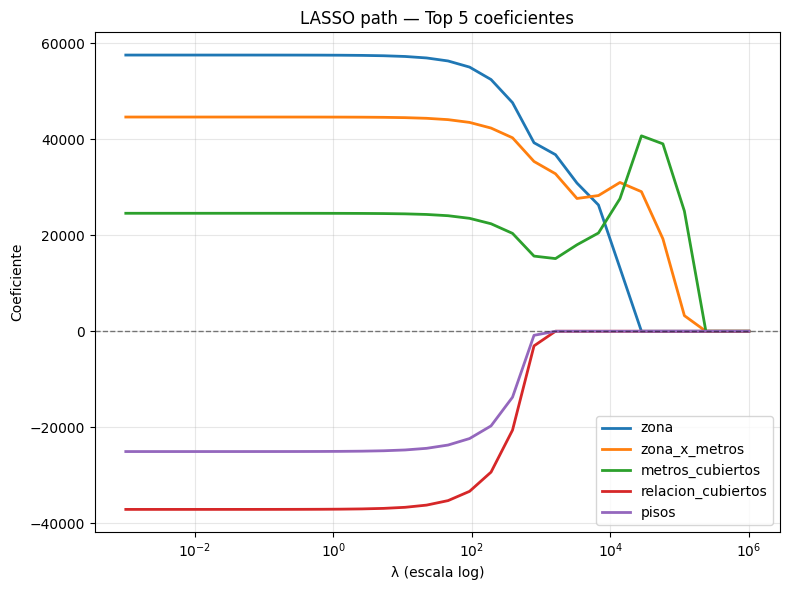

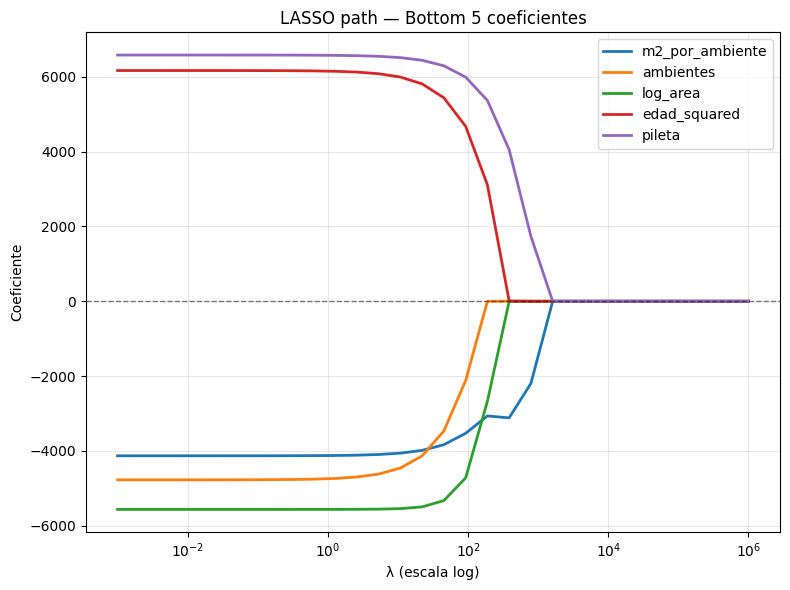

In [23]:

# Preparo los  nombres y matriz sin bias

if Ws.shape[1] == len(features_m4) + 1:
    Ws_no_b = Ws[:, 1:]
    feat_names = list(features_m4)
else:
    Ws_no_b = Ws
    feat_names = list(features_m4)  

# Importancia por feature: max |coef| a lo largo de todas las lambdas
importance = np.max(np.abs(Ws_no_b), axis=0)

# Indices Top 5 y Bottom 5
order = np.argsort(importance)   # ascendente
bottom5_idx = order[:5]          # menores importancias
top5_idx    = order[-5:][::-1]   # mayores importancias (desc)

top5_feats = [feat_names[i] for i in top5_idx]
bottom5_feats = [feat_names[i] for i in bottom5_idx]

print("Top 5 (por max |coef| en el path):")
for i, f in zip(top5_idx, top5_feats):
    print(f"  {f:>20s}  max|w|={importance[i]:.4g}")

print("\nBottom 5 (por max |coef| en el path):")
for i, f in zip(bottom5_idx, bottom5_feats):
    print(f"  {f:>20s}  max|w|={importance[i]:.4g}")

# Función de ploteo para un conjunto de índices
def plot_lasso_subset(Ls, Ws_sub, idxs, labels, title):
    plt.figure(figsize=(8,6))
    for j, i in enumerate(idxs):
        plt.semilogx(Ls, Ws_sub[:, i], label=labels[j], linewidth=2)
    plt.axhline(0, color="k", lw=1, ls="--", alpha=0.5)
    plt.xlabel("λ (escala log)")
    plt.ylabel("Coeficiente")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Grafico 
plot_lasso_subset(Ls, Ws_no_b, top5_idx, top5_feats,  "LASSO path — Top 5 coeficientes")
plot_lasso_subset(Ls, Ws_no_b, bottom5_idx, bottom5_feats, "LASSO path — Bottom 5 coeficientes")


Teniendo en cuenta los valores obtenidos para ambos modelos los resultados son los siguientes:

Top 5 features para Ridge:
- sqrt_area 
- sqrt_metros_cubiertos 
- Área 
- log_area 
- metros_cubiertos  

Bottom 5 features para Ridge:
- m2_por_ambiente  max|w|=3597
- ambientes  max|w|=3809
- ambientes_squared  max|w|=4851
- edad_squared  max|w|=5032
- pileta  max|w|=5613


Top 5 features para Lasso:
- zona 
- zona_x_metros 
- metros_cubiertos  
- relacion_cubiertos
- pisos  

Bottom 5 features para Lasso:
- m2_por_ambiente 
- ambientes 
- log_area  
- edad_squared  
- pileta  

Habiendo realizado ambos modelos y viendo el efecto de las dos regularizaciones en los coeficientes saco las siguientes conclusiones:

Ridge (L2) reduce los valores de todos los coeficientes de forma continua, pero rara vez los lleva exactamente a cero. Esto significa que mantiene todas las variables en el modelo, aunque con menor peso.

Lasso (L1), en cambio, tiende a forzar varios coeficientes exactamente a cero. Por eso, tambien actúa como un método de selección automática de variables.

Evaluo cual es el mejor lambda para el modelo.

Mejor λ (Ridge): 0.0161026 | ECM=1540517818.6229
Mejor λ (Lasso): 0.0001 | ECM=1716842402.4208


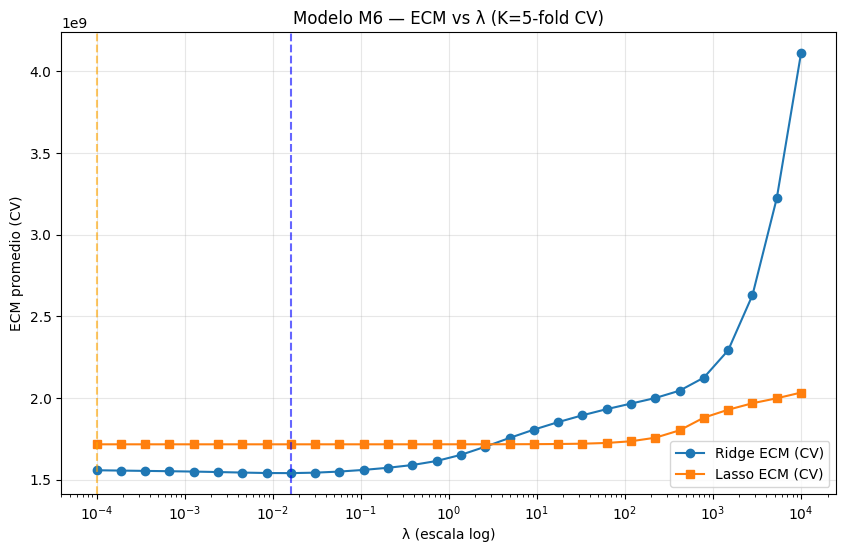

In [24]:

# Configuración
TARGET = "precio"
K = 5   # número de folds
lambdas = np.logspace(-4, 4, 30)  # grid de λ

# Dataset asumido en df (features + target)
feature_names = [c for c in df_feat.columns if c != TARGET]
n = len(df_feat)
idx = np.arange(n)
rng = np.random.default_rng(42)
rng.shuffle(idx)

folds = np.array_split(idx, K)

# Función de evaluación
def cv_mse(lam, mode="ridge"):
    mses = []
    for k in range(K):
        val_idx = folds[k]
        train_idx = np.hstack([folds[i] for i in range(K) if i != k])

        train_df = df_feat.iloc[train_idx].copy()
        val_df   = df_feat.iloc[val_idx].copy()

        # Normalización (precio NO se toca)
        train_norm, val_norm, mu, sigma = pre.normalize(train_df, val_df, target_name=TARGET)
        X_train = train_norm[feature_names].values
        y_train = train_norm[TARGET].values
        X_val   = val_norm[feature_names].values
        y_val   = val_norm[TARGET].values

        model = models.RegresionLineal(X_train, y_train, estandarizar=False, feature_names=feature_names)

        if mode == "ridge":
            model.entrenar_ridge(lam)
        elif mode == "lasso":
            model.entrenar_lasso(lam=lam, max_iter=5000, tol=1e-6)
        else:
            raise ValueError("mode debe ser 'ridge' o 'lasso'")

        y_pred = model.predecir(X_val)
        mses.append(metrics.mse(y_val, y_pred))
    return np.mean(mses)

# Barrido de Lambdas
ridge_mse = [cv_mse(lam, mode="ridge") for lam in lambdas]
lasso_mse = [cv_mse(lam, mode="lasso") for lam in lambdas]

best_lambda_ridge = lambdas[np.argmin(ridge_mse)]
best_lambda_lasso = lambdas[np.argmin(lasso_mse)]

print(f"Mejor λ (Ridge): {best_lambda_ridge:.6g} | ECM={min(ridge_mse):.4f}")
print(f"Mejor λ (Lasso): {best_lambda_lasso:.6g} | ECM={min(lasso_mse):.4f}")


# Gráfico ECM vs Lambdas
plt.figure(figsize=(10,6))
plt.semilogx(lambdas, ridge_mse, marker="o", label="Ridge ECM (CV)")
plt.semilogx(lambdas, lasso_mse, marker="s", label="Lasso ECM (CV)")
plt.axvline(best_lambda_ridge, ls="--", color="blue", alpha=0.6)
plt.axvline(best_lambda_lasso, ls="--", color="orange", alpha=0.6)
plt.xlabel("λ (escala log)")
plt.ylabel("ECM promedio (CV)")
plt.title(f"Modelo M6 — ECM vs λ (K={K}-fold CV)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Interpretando el grafico de arriba, para M6 voy a utilizar Ridge con el lambda optimo ya que aunque lasso parece que pueda tener un optimo mas chico si agrando la escala del lamnda, se mantiene igual para valores mas chicos y siempre por arriba de Riedge.

Entonces en resumen:

Modelo M6: Riedge Regression con las caracteristicas de M4 y Lambda optimo= 0.0161026 

In [25]:
X_train_m6 = X_train_m4
y_train_m6 = y_train_m4
X_val_m6 = X_val_m4
y_val_m6 = y_val_m4

features_m6 = features_m4
print(f"λ*: {best_lambda_ridge:.6g}")

print("Entrenando modelo M6 (Ridge) con mejor λ...")

modelo_m6 = models.RegresionLineal(X_train_m6, y_train_m6, estandarizar=False, feature_names=features_m6)
modelo_m6.entrenar_ridge(lam=best_lambda_ridge)


λ*: 0.0161026
Entrenando modelo M6 (Ridge) con mejor λ...


Seleccion de Modelo y Evaluacion de Capacidad Predictiva

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def learning_curve(model_class, X_train, y_train, X_val, y_val, mode="ols", lam=None, n_splits=10, feature_names=None):
    """
    Construye curvas de aprendizaje usando SOLO el train para aumentar el tamaño,
    y evalúa siempre en el mismo conjunto de validación.
    """
    n = len(X_train)
    sizes = np.linspace(0.1, 1.0, n_splits)

    train_ecm, val_ecm = [], []

    for frac in sizes:
        n_sub = max(20, int(frac * n))
        X_sub, y_sub = X_train[:n_sub], y_train[:n_sub]

        model = model_class(X_sub, y_sub, estandarizar=False, feature_names=feature_names)
        if mode == "ols":
            model.entrenar_pseudoinversa()
        elif mode == "ridge":
            model.entrenar_ridge(lam)
        elif mode == "lasso":
            model.entrenar_lasso(lam=lam, max_iter=5000, tol=1e-6)

        yhat_train = model.predecir(X_sub)
        yhat_val   = model.predecir(X_val)

        train_ecm.append(metrics.mse(y_sub, yhat_train))
        val_ecm.append(metrics.mse(y_val, yhat_val))

    return sizes * 100, np.array(train_ecm), np.array(val_ecm)


def plot_learning_curves(results, title="Learning Curves"):
    plt.figure(figsize=(12, 5))
    for name, (sizes, tr, va) in results.items():
        plt.plot(sizes, np.log10(va), marker="o", label=f"{name} val")
        plt.plot(sizes, np.log10(tr), marker="s", linestyle="--", label=f"{name} train")
    plt.xlabel("% datos de entrenamiento")
    plt.ylabel("log10(ECM)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


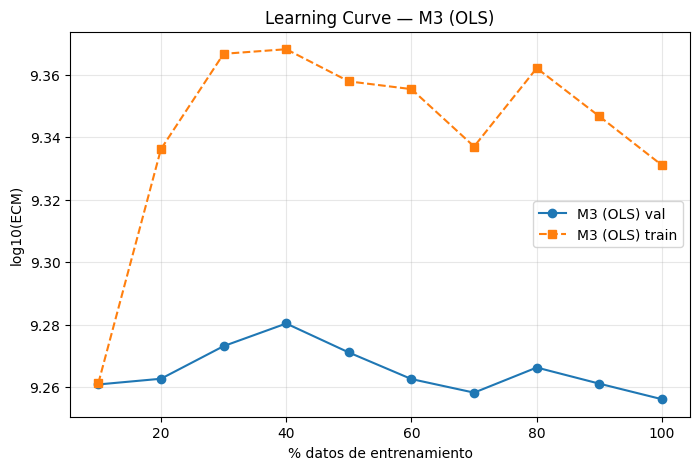

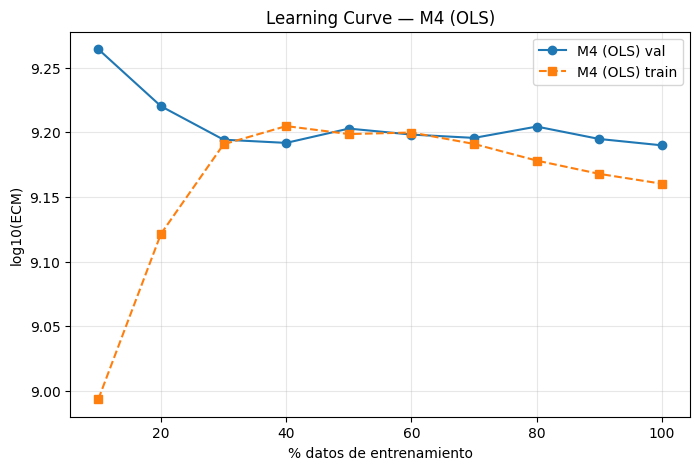

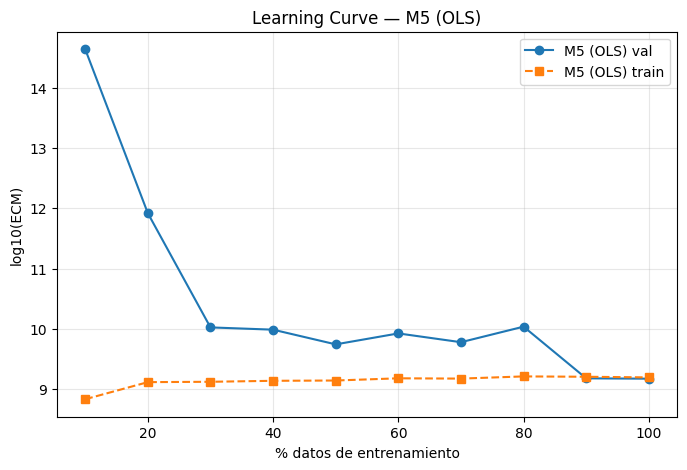

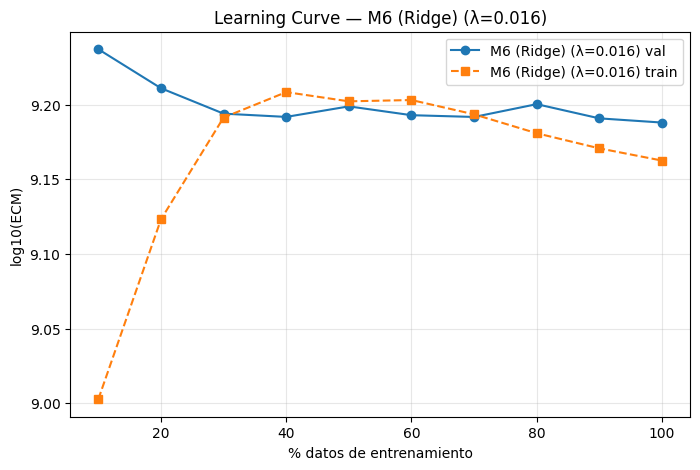

In [27]:
# Ejemplo con M3, M4, M5 y Ridge/Lasso con lamdas optimos

results = {}

sizes, tr, va = learning_curve(models.RegresionLineal, X_train_m3, y_train_m3, X_val_m3, y_val_m3, mode="ols", feature_names=features_m3)
results["M3 (OLS)"] = (sizes, tr, va)

sizes, tr, va = learning_curve(models.RegresionLineal, X_train_m4, y_train_m4, X_val_m4, y_val_m4, mode="ols", feature_names=features_m4)
results["M4 (OLS)"] = (sizes, tr, va)

sizes, tr, va = learning_curve(models.RegresionLineal, X_train_m5, y_train_m5, X_val_m5, y_val_m5, mode="ols", feature_names=features_m5)
results["M5 (OLS)"] = (sizes, tr, va)

sizes, tr, va = learning_curve(models.RegresionLineal, X_train_m4, y_train_m4, X_val_m4, y_val_m4, mode="ridge", lam=best_lambda_ridge, feature_names=features_m4)
results[f"M6 (Ridge) (λ={best_lambda_ridge:.2g})"] = (sizes, tr, va)


# Graficar cada curva de aprendizaje por separado
for name, (sizes, tr, va) in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(sizes, np.log10(va), marker="o", label=f"{name} val")
    plt.plot(sizes, np.log10(tr), marker="s", linestyle="--", label=f"{name} train")
    plt.xlabel("% datos de entrenamiento")
    plt.ylabel("log10(ECM)")
    plt.title(f"Learning Curve — {name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Teniendo en cuenta los resultados obtenidos defino M6 como mi modelo para produccion.

M6 Tiene un desempeño en validacion parecido al de M4.

La regularización L2 lo hace más estable ante muestras nuevas.

Me evita problemas de sobreajuste y de coeficientes extremos, que son comunes cuando hay correlación fuerte entre las features.

M5 lo descartaría porque la curva muestra claramente sobreajuste. M4 es aceptable, pero Ridge me da ese extra de seguridad.

Ahora veamos como se comporta el modelo evaluado en el set de Test:

Evaluación final en el set de Test:
MAE (test):  24,500.54
RMSE (test): 38,365.42


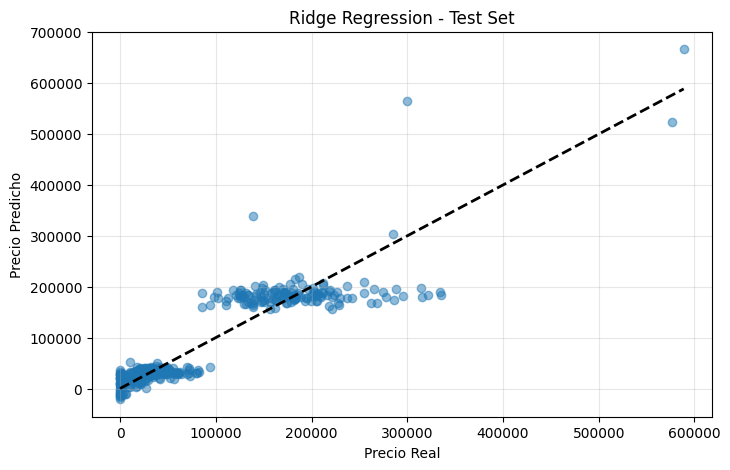

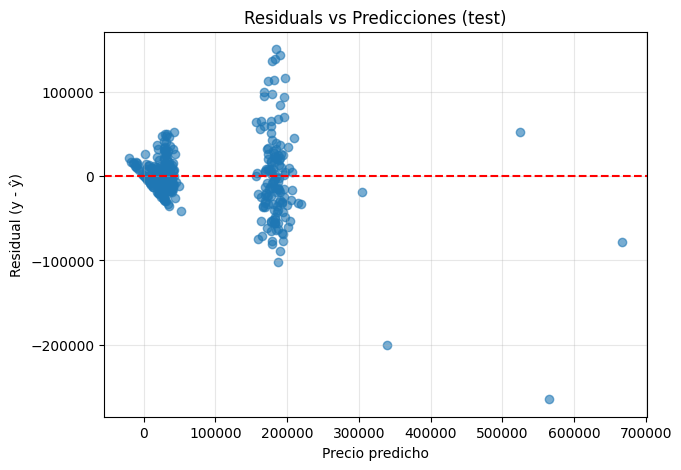

In [28]:

# Evaluación final en el set de Test
df_feat_norm = df_feat.copy()

# Calculo mu y sigma de las columnas numéricas (sin el target)
num_cols = df_feat.select_dtypes(include="number").columns.drop("precio")
mu = df_feat[num_cols].mean()
sigma = df_feat[num_cols].std()

# Normalizo df_feat usando mu y sigma calculados
df_feat_norm[num_cols] = (df_feat[num_cols] - mu) / sigma

X_trainval= df_feat_norm[feature_names].values
y_trainval= df_feat_norm["precio"].values

df_test_norm = df_test_feat.copy()
df_test_norm[num_cols] = (df_test_norm[num_cols] - mu) / sigma
31
X_test = df_test_norm[feature_names].values
y_test = df_test_norm["precio"].values

# Ejemplo con Ridge (modelo final seleccionado)
model = models.RegresionLineal(X_trainval, y_trainval, estandarizar=False, feature_names=feature_names)
model.entrenar_ridge(best_lambda_ridge) #Uso el mejor lambda que obtuve antes

yhat_test = model.predecir(X_test)

# Métricas
mae_test = metrics.mae(y_test, yhat_test)
rmse_test = metrics.rmse(y_test, yhat_test)

print("Evaluación final en el set de Test:")
print(f"MAE (test):  {mae_test:,.2f}")
print(f"RMSE (test): {rmse_test:,.2f}")

#Graficar
plt.figure(figsize=(8, 5))
plt.scatter(y_test, yhat_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Ridge Regression - Test Set")
plt.grid(True, alpha=0.3)
plt.show()

res = y_test - yhat_test

plt.figure(figsize=(7,5))
plt.scatter(yhat_test, res, alpha=0.6)
plt.axhline(0, color="r", ls="--")
plt.xlabel("Precio predicho")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predicciones (test)")
plt.grid(alpha=0.3)
plt.show()

